In [2]:
import os
import pandas as pd 
import numpy as np
import joblib

from rdkit import Chem
from rdkit.Chem import Crippen
from mapchiral.mapchiral import encode

from matplotlib.colors import ListedColormap, LogNorm 
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Menlo"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams.update({'font.size': 22})

#### Datasets

Read data

In [3]:
activity = joblib.load('data/activity_clean_features.pkl')
hemolysis = joblib.load('data/hemolysis_clean_features.pkl')

Merge data

In [4]:
merged = pd.merge(activity, hemolysis, on=['sequence', 'helicity', 'hydrophobic_moment'], how='left')
merged.rename(columns={'label_x':'activity', 'label_y':'hemolysis', 'map4_x': 'map4'}, inplace=True)
merged.fillna(-1, inplace=True)
merged.sort_values(by=['activity', 'hemolysis'], inplace=True)
merged = merged[['sequence', 'activity', 'hemolysis', 'helicity', 'hydrophobic_moment', 'map4']].copy()

Calculate fingerprints and properties

In [5]:
def FracC(mol):
    smarts = Chem.MolFromSmarts('[C]')
    return len(mol.GetSubstructMatches(smarts, uniquify=True))/len(mol.GetAtoms())

merged['mol'] = merged['sequence'].apply(lambda x: Chem.MolFromSequence(x))
merged['hac'] = merged['mol'].apply(lambda x: x.GetNumHeavyAtoms())
merged['frac_c'] = merged['mol'].apply(FracC)

In [6]:
merged[['sequence', 'activity', 'hemolysis', 'hac', 'frac_c', 'helicity', 'hydrophobic_moment']].to_csv('tmap_data/merged.csv', index=False)

#### Cross-Validations

Plot cross-validation results of the activity and hemolysis models

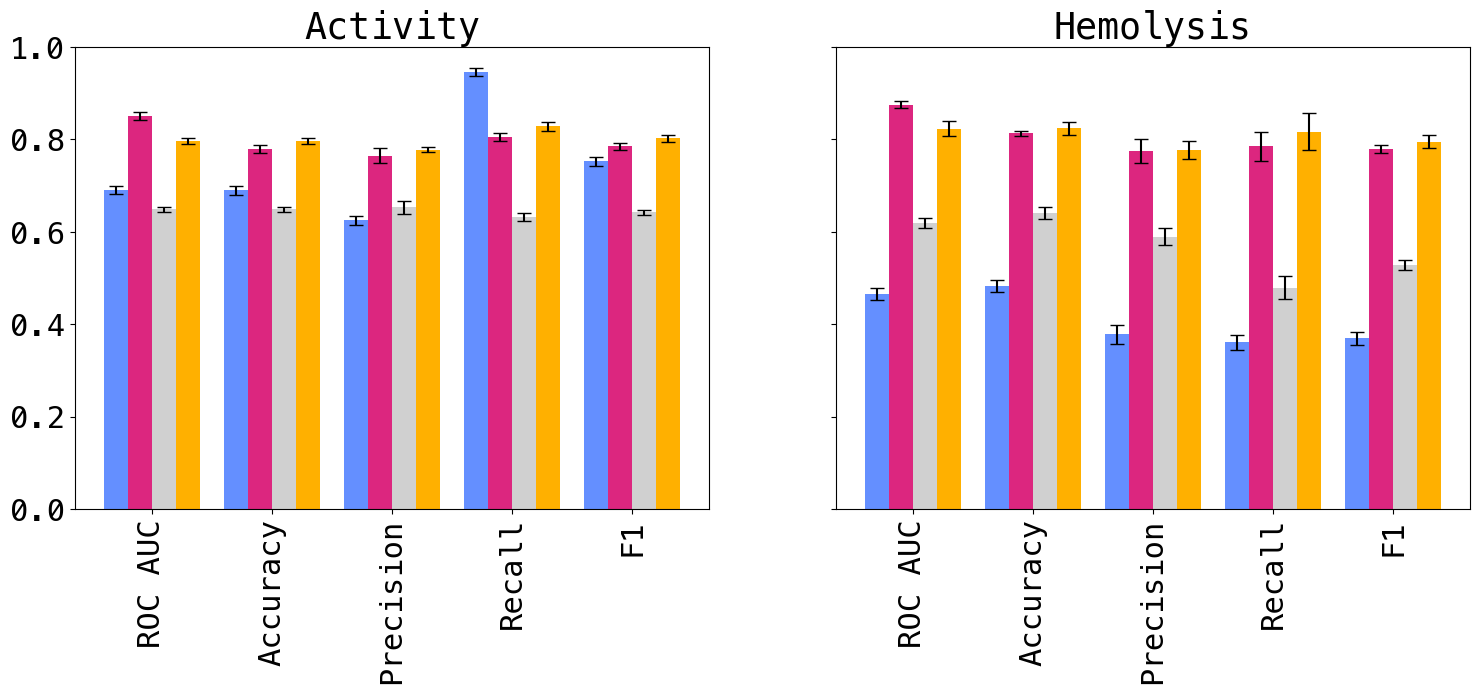

In [34]:
filenames = os.listdir('results/')
filenames.sort()

metrics = ('ROC AUC', 'Accuracy', 'Precision', 'Recall', 'F1')
colors = ['#648FFF', '#DC267F', '#D0D0D0', '#FFB000', '#648FFF', '#DC267F', '#FFB000','#D0D0D0', '#FFB000']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

activity_means = []
activity_stds = []

hemolysis_means = []
hemolysis_stds = []

for file in filenames:

    df = pd.read_csv('results/' + file)

    model_name = ' '.join(file.split('_')[:-1])
    mean_values = df.iloc[-2, 1:].values.tolist()
    std_values = df.iloc[-1, 1:].values.tolist()

    if 'activity' in file:
        activity_means.append(mean_values)
        activity_stds.append(std_values)
    
    elif 'hemolysis' in file:
        hemolysis_means.append(mean_values)
        hemolysis_stds.append(std_values)

x = np.arange(len(metrics))
width = 0.2

for i in range(len(activity_means)):
    ax1.bar(x + i * width, activity_means[i], width, label=' '.join(filenames[i].split('_')[:-1]), yerr=activity_stds[i], capsize=5, color=colors[i])

for i in range(len(hemolysis_means)):
    ax2.bar(x + i * width, hemolysis_means[i], width, label=' '.join(filenames[i].split('_')[:-1]), yerr=hemolysis_stds[i], capsize=5, color=colors[i])

ax1.set_xticks(x + 1.5 * width)
ax2.set_xticks(x + 1.5 * width)

ax1.set_xticklabels(metrics, rotation=90)
ax2.set_xticklabels(metrics, rotation=90)

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)

ax1.title.set_text('Activity')
ax2.title.set_text('Hemolysis')

plt.savefig('figures/metrics.png', dpi=1200, bbox_inches='tight')